# Behavior of the Perceptron convergence
Below we import the entire Perceptron code from the previous example:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

In [3]:
np.random.seed(0)

In [4]:
# module for file access
import os.path

# global file name of our data source
file_name = 'iris.csv'

def fetch_iris_data():
    '''
    Fetch data from an internet archive and save as file `iris.csv`.
    '''

    df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                     header=None)
    df.to_csv(file_name, header=None, index=False)

    return

# fetch data from internet source only if the file is not available locally
if not os.path.exists(file_name):
    fetch_iris_data()
    
df = pd.read_csv(file_name, header=None)

In [5]:
def prep_iris_data(df):
    ''' 
    Fetches 2d data points from the iris data from the pandas dataframe `df` and
    return (X, Y), where X is a list of 2d points and Y a list of labels.
    '''
    
    # as feature we take the first two data entries,
    # which are sepal length and width
    X = df.iloc[:, 0:2].values

    # read class labels and convert them to numers as follow:
    # `iris-setosa` set to value -1, `iris-versicol` as well as `iris-virginica` to value 1
    Y = df.iloc[:, 4].values 
    Y = np.where(Y == 'Iris-setosa', -1, 1)
    
    # to make it more realistic, we randomize the data
    indices = np.random.permutation(len(X))
    X_rand = [X[i] for i in indices]
    Y_rand = [Y[i] for i in indices]

    # return the randomized lists as numpy arrays
    return np.array(X_rand), np.array(Y_rand)

In [6]:
def plot_data(X, Y):
    '''
    Plot the data X, setosa in red, and others in blue.
    '''

    # divide data depedning on the label: iris-setosa or other
    X_setosa = []
    X_other = []
    for x, y in zip(X, Y):
        if y == -1:
            X_setosa.append(x)
        else:
            X_other.append(x)
   
    # convert to numpy array
    X_setosa = np.array(X_setosa)
    X_other = np.array(X_other)

    # plot the two lists with different styles
    plt.scatter(X_setosa[:, 0], X_setosa[:, 1], color='red', marker='o', label='setosa')
    plt.scatter(X_other[:, 0], X_other[:, 1], color='blue', marker='o', label='other')

    # decorate plot
    plt.xlabel('sepal length')
    plt.ylabel('sepal width')
    plt.legend(loc='upper right')

    return

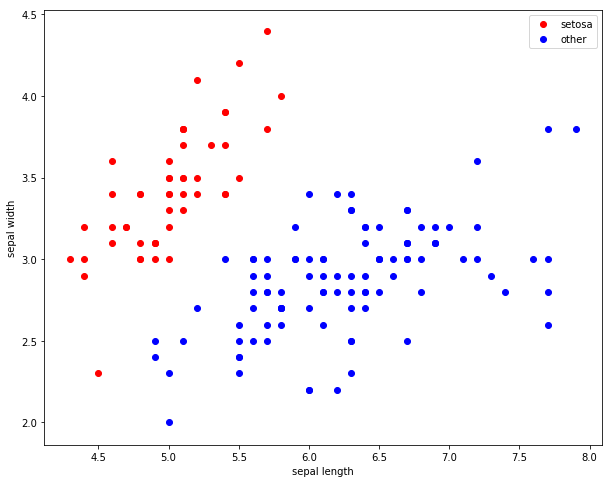

In [7]:
X_all, Y_all = prep_iris_data(df)

plot_data(X_all, Y_all)

In [8]:
class Perceptron:

    def __init__(self, num):
        '''
        initialize class for `num` input signals
        '''

        # weights of the perceptron, initialized to zero
        # note the '1 + ' as the first weight entry is the threshold
        self.w_ = np.zeros(1 + num)

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return np.where(self.activation_input(X) >= 0.0, 1, -1)

    def learn(self, X_train, Y_train, eta=0.01, epochs=10):
        '''
        fit training features X_train with labels Y_train according to learning rate
        `eta` and total number of epochs `epochs` and log the misclassifications in errors_
        '''

        # reset internal list of misclassifications for the logging
        self.train_errors_ = []
        # start a list storing the weight vectors during learning
        self.train_ws_ = [np.array(self.w_)] # note that we need to copy the array (therenfore the
                                             # additional `np.array()` function) not just the reference!

        # repeat `epochs` many times
        for _ in range(epochs):
            err = 0
            # for each pair of features and corresponding label
            for x, y in zip(X_train, Y_train):
                # compute the update for the weight coefficients
                update = eta * ( y - self.classify(x) )
                # update the weights
                self.w_[1:] += update * x
                # update the threshold
                self.w_[0] += update
                self.train_ws_.append(np.array(self.w_))
                # increment the number of misclassifications if update is not zero
                err += int(update != 0.0)
            # append the number of misclassifications to the internal list
            self.train_errors_.append(err)
    
        return

    def plot_decision_regions(self, X, Y, X_train, Y_train, resolution):

        # set up a 2d mesh of data points with resolution `resolution`
        x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
        x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # start new plot
        fig = plt.figure()
        axs = plt.gca()

        # make fictitious feature data out of the above 2d mesh
        x_mesh = np.array( [xx1.ravel(), xx2.ravel()] ).T
        # let the perceptron classify these features
        Z = self.classify(x_mesh)
        Z = Z.reshape(xx1.shape)

        # plot the mesh as contour plot
        axs.contourf(xx1, xx2, Z, alpha=0.4, cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
        axs.set_xlim(xx1.min(), xx1.max())
        axs.set_ylim(xx2.min(), xx2.max())
        
        # sort the input data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X, Y):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)

        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='.', label='Setosa')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='.', label='Other')
        
        # sort the training data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X_train, Y_train):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)
        
        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='x', label='S. training')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='x', label='O. training')

        # add some additional annotations of the plot
        axs.set_xlabel('sepal length')
        axs.set_ylabel('sepal width')
        axs.legend(loc='upper right')
        axs.set_title('Perceptron')

        return

    def plot_train_errors(self):
        '''
        plot the number of misclassifications per epoch
        '''

        # create two list, one with epoch numbers, and one with the errors per epoch
        epochs, num_errs = np.arange(len(self.train_errors_)), np.array(self.train_errors_)

        # plot the above data
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('errors')
        axs.set_title('Errors during training')
        plt.plot(epochs, num_errs)

        return

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

## Dependence on learning rates
Our objective is to visualize the learning process and get an idea about the dependence on training data as well as the learning rate.

First we look at two training phases with learning rates that are two orders of magnitude apart.

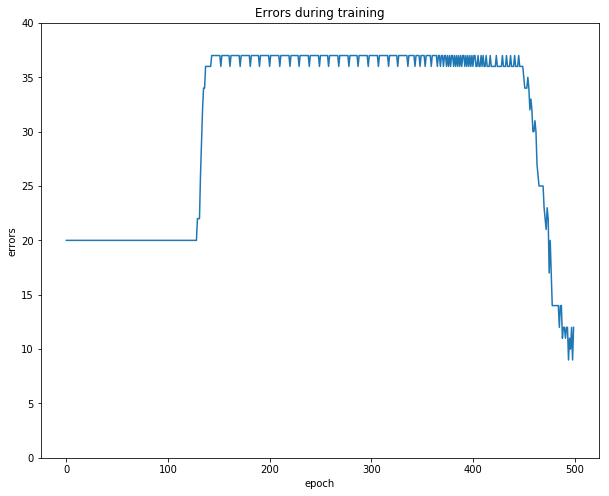

weights: [ 0.234    0.00416 -0.0775 ]
Efficiency (train) = 0.78
Efficiency (test)  = 0.87
Efficiency (all)   = 0.84


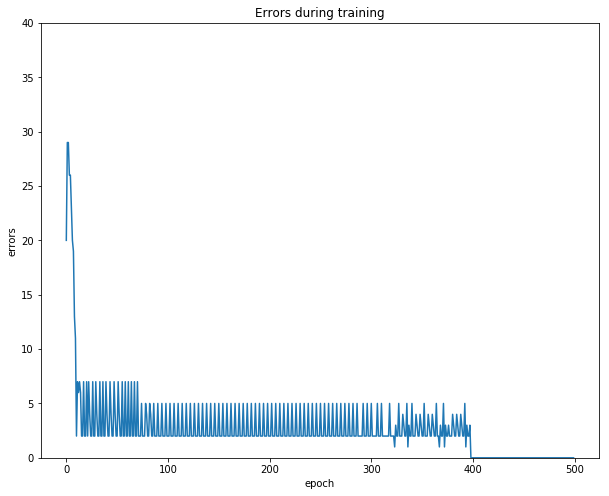

weights: [-1.76   1.112 -1.412]
Efficiency (train) = 1.0
Efficiency (test)  = 1.0
Efficiency (all)   = 1.0


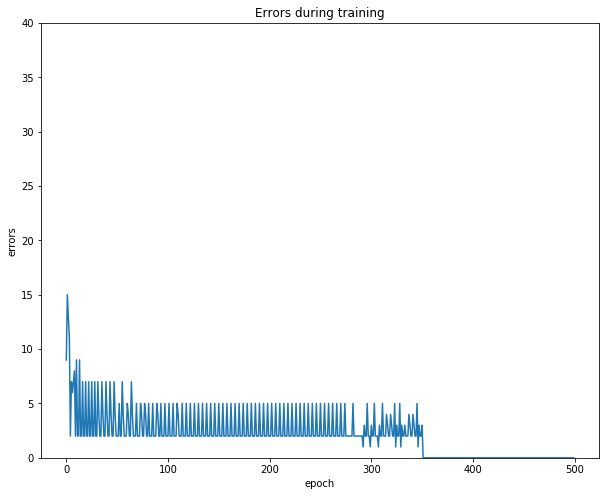

weights: [-1739.  1106. -1409.]
Efficiency (train) = 1.0
Efficiency (test)  = 1.0
Efficiency (all)   = 1.0


In [9]:
np.random.seed(2)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ppn = Perceptron(X.shape[1])
ppn.w_ = np.array([1, 2, 3], dtype=np.float64)
ppn.learn(X_train, Y_train, eta=0.0001, epochs=500)
ppn.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ppn.efficiency(X_train, Y_train)
eff_test = ppn.efficiency(X, Y)
eff_all = ppn.efficiency(X_all, Y_all)

print('weights:', ppn.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

ppn = Perceptron(X.shape[1])
ppn.w_ = np.array([1, 2, 3], dtype=np.float64)
ppn.learn(X_train, Y_train, eta=0.01, epochs=500)
ppn.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ppn.efficiency(X_train, Y_train)
eff_test = ppn.efficiency(X, Y)
eff_all = ppn.efficiency(X_all, Y_all)

print('weights:', ppn.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

ppn = Perceptron(X.shape[1])
ppn.w_ = np.array([1, 2, 3], dtype=np.float64)
ppn.learn(X_train, Y_train, eta=10, epochs=500)
ppn.plot_train_errors()

plt.ylim((0,40))
plt.show()

eff_train = ppn.efficiency(X_train, Y_train)
eff_test = ppn.efficiency(X, Y)
eff_all = ppn.efficiency(X_all, Y_all)

print('weights:', ppn.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

We observe that a too low learning rate requires many epochs until we get a good classificatio result. Of course, this is due to the fact that for every misclassification the update of the weight vector is multiplied by the learning rate. Hence, only small changes in the weight vector occur and those have to accumulate over a longer period of time to reach convergence. Note also that a very high learning rate does in turn not result in a better convergence – in our example, the converges is very fast at the beginning but then stagnates for quite a long time.

### Sequence of decission boundaries per epoch
Next let us visualize what updates occur during the training.

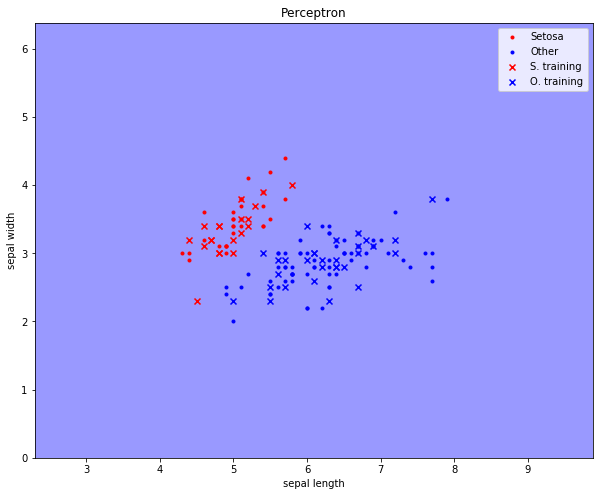

Epoch: 0
weights: [1. 2. 3.]
Efficiency (train) = 0.6
Efficiency (test)  = 0.7
Efficiency (all)   = 0.6666666666666667


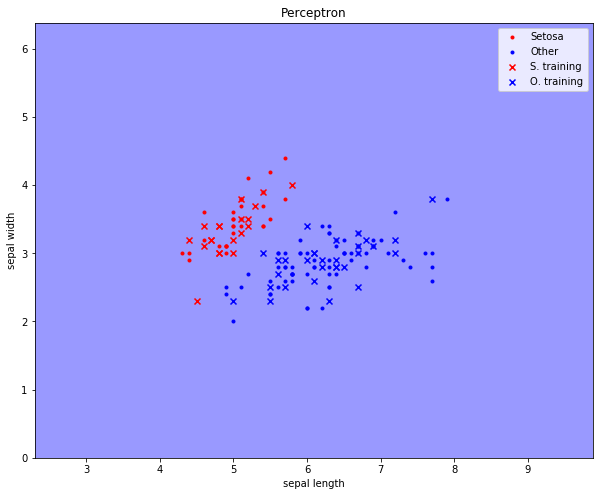

Epoch: 1
weights: [0.6   0.022 1.67 ]
Efficiency (train) = 0.6
Efficiency (test)  = 0.7
Efficiency (all)   = 0.6666666666666667


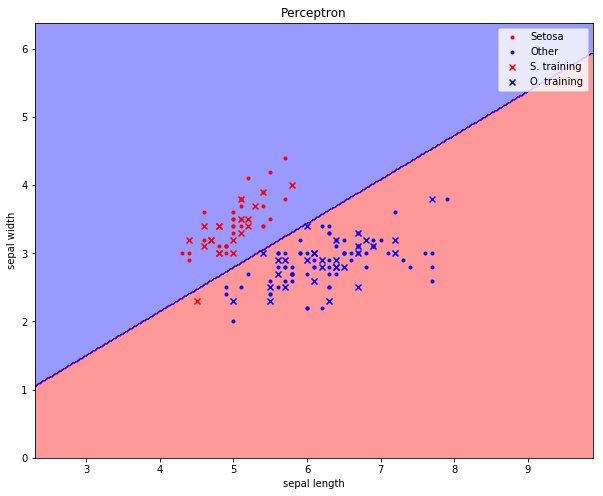

Epoch: 2
weights: [ 0.42  -0.616  0.954]
Efficiency (train) = 0.020000000000000018
Efficiency (test)  = 0.0
Efficiency (all)   = 0.00666666666666671


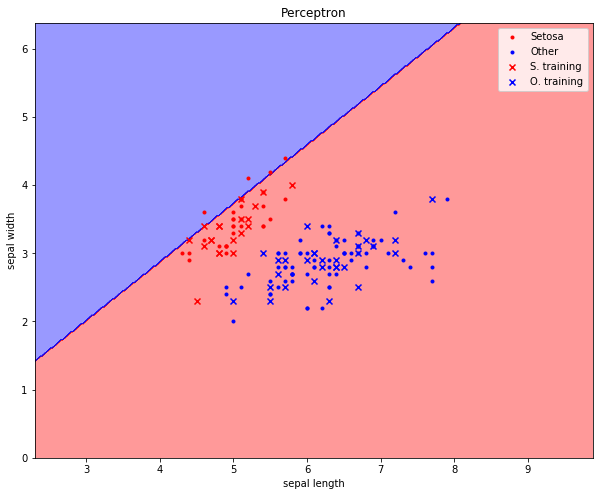

Epoch: 3
weights: [ 0.36  -0.548  0.638]
Efficiency (train) = 0.38
Efficiency (test)  = 0.26
Efficiency (all)   = 0.30000000000000004


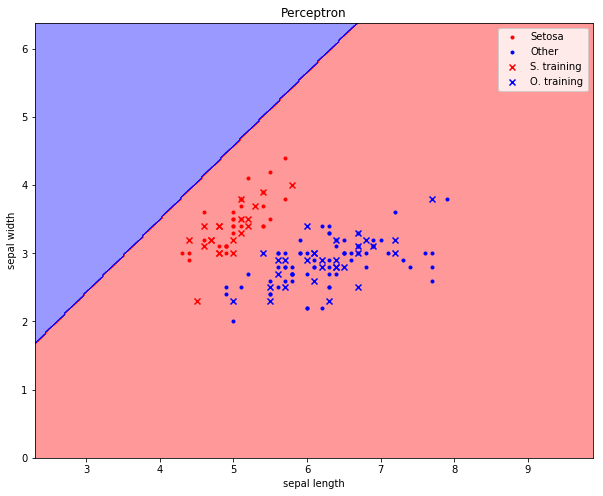

Epoch: 4
weights: [ 0.32  -0.428  0.398]
Efficiency (train) = 0.4
Efficiency (test)  = 0.30000000000000004
Efficiency (all)   = 0.33333333333333337


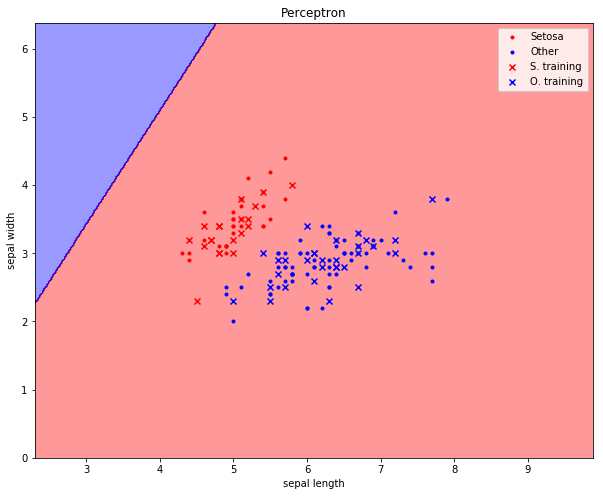

Epoch: 5
weights: [ 0.28  -0.294  0.176]
Efficiency (train) = 0.4
Efficiency (test)  = 0.30000000000000004
Efficiency (all)   = 0.33333333333333337


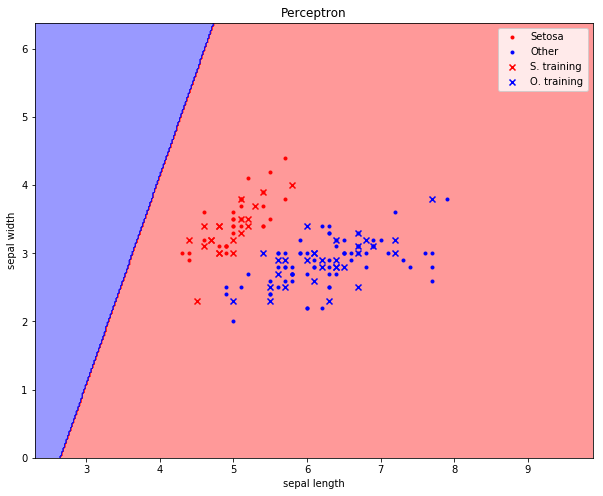

Epoch: 6
weights: [ 0.26  -0.098  0.032]
Efficiency (train) = 0.4
Efficiency (test)  = 0.30000000000000004
Efficiency (all)   = 0.33333333333333337


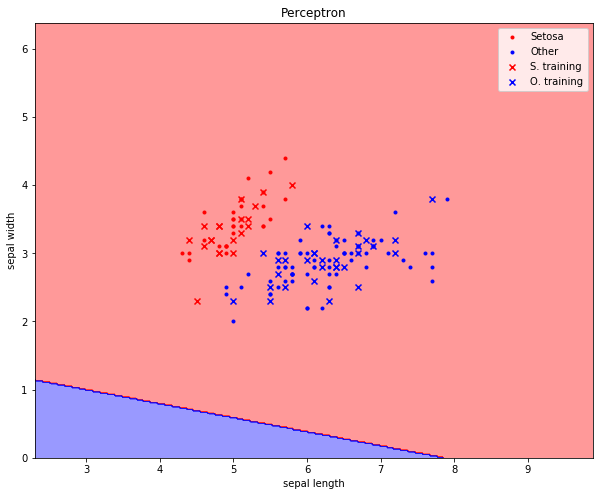

Epoch: 7
weights: [ 0.22  -0.028 -0.136]
Efficiency (train) = 0.4
Efficiency (test)  = 0.30000000000000004
Efficiency (all)   = 0.33333333333333337


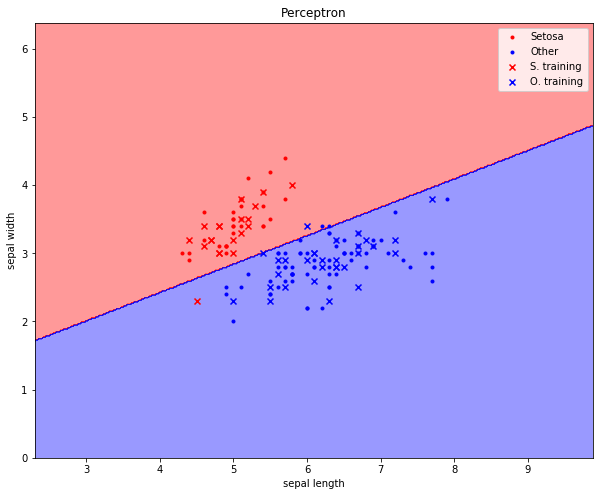

Epoch: 8
weights: [ 0.2    0.11  -0.264]
Efficiency (train) = 0.96
Efficiency (test)  = 0.98
Efficiency (all)   = 0.9733333333333334


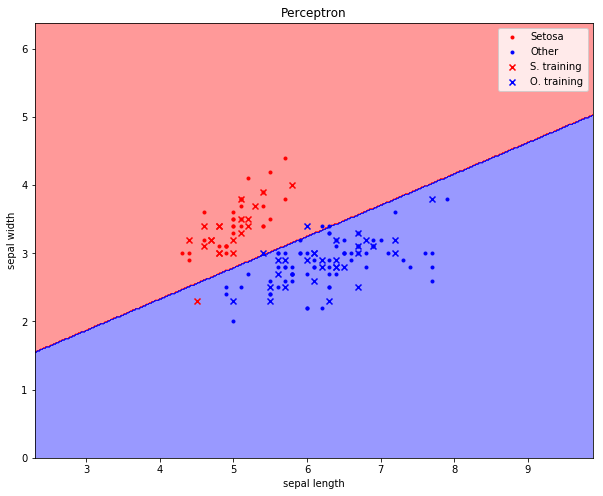

Epoch: 9
weights: [ 0.18   0.168 -0.366]
Efficiency (train) = 0.94
Efficiency (test)  = 0.97
Efficiency (all)   = 0.96


In [10]:
np.random.seed(2)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

ppn = Perceptron(X.shape[1])
ppn.w_ = np.array([1, 2, 3], dtype=np.float64)

for e in range(10):
    
    ppn.plot_decision_regions(X, Y, X_train, Y_train, 0.02)
    eff_all = ppn.efficiency(X_all, Y_all)
    
    eff_train = ppn.efficiency(X_train, Y_train)
    eff_test = ppn.efficiency(X, Y)
    eff_all = ppn.efficiency(X_all, Y_all)
    
    plt.show()

    print('Epoch:', e )
    print('weights:', ppn.w_)
    print('Efficiency (train) =', eff_train)
    print('Efficiency (test)  =', eff_test)
    print('Efficiency (all)   =', eff_all)
    
    ppn.learn(X_train, Y_train, eta=0.01, epochs=1)

First, note that in the beginning the classification was not too bad but the outliner then pushes the weight vector a little too much so that the number of misclassicifations rises (the spike in the errors per epoch plots) before the Perceptron converges again. Second, the classification efficienty will not become much better but will start to oscillate as there are points in the training data set are not linearly seperable (the misclassified one near the boundary). This is where the oscillations in the errors per epoch plots above come from.

## Dependence on bad points
The Perceptron behaves especially bad when training with data that includes a data point that violates the linear separability very strongly. In the following we replace the first point in the data set which is included in the subset that is used for the trainning. 

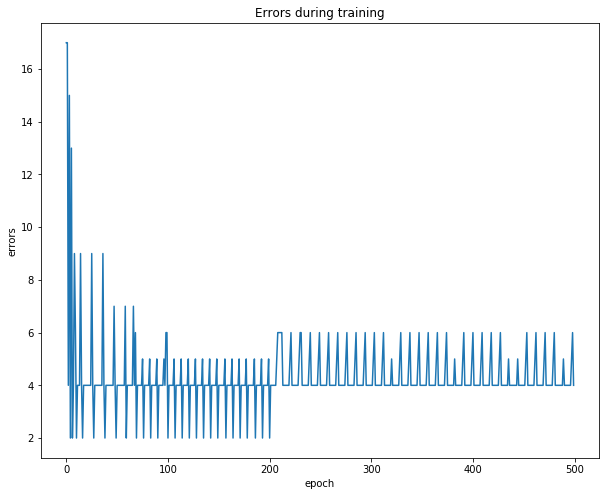

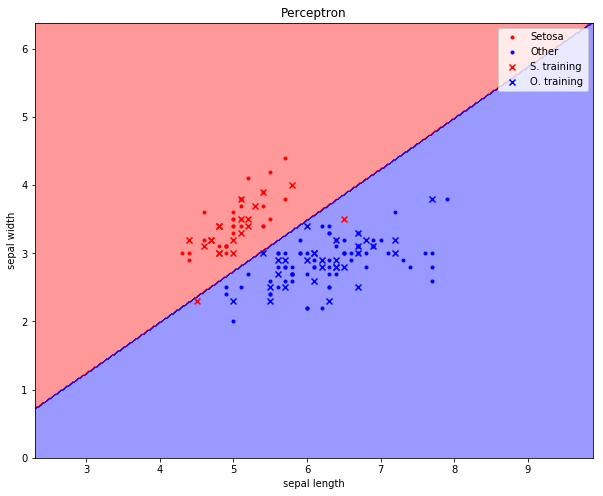

weights: [-12.4    9.18 -12.26]
Efficiency (train) = 0.96
Efficiency (test)  = 1.0
Efficiency (all)   = 0.9866666666666667


In [11]:
# fix the generated random numbers (2 seems to select a bad case)
np.random.seed(4)
# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ppn = Perceptron(X.shape[1])
ppn.learn(X_train, Y_train, eta=0.1, epochs=500)
ppn.plot_train_errors()

ppn.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = ppn.efficiency(X_train, Y_train)
eff_test = ppn.efficiency(X, Y)
eff_all = ppn.efficiency(X_all, Y_all)

plt.show()

print('weights:', ppn.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

Note that the number of errors even increases around the 200th epoch. The oscillation is simply due to the fact that there will always be a misclassification no matter how we update as the training data set is not linearly separable. The stronger the violation of the linear separability is the stronger we may expect the oscillation. Let us visualize what happens during the training.

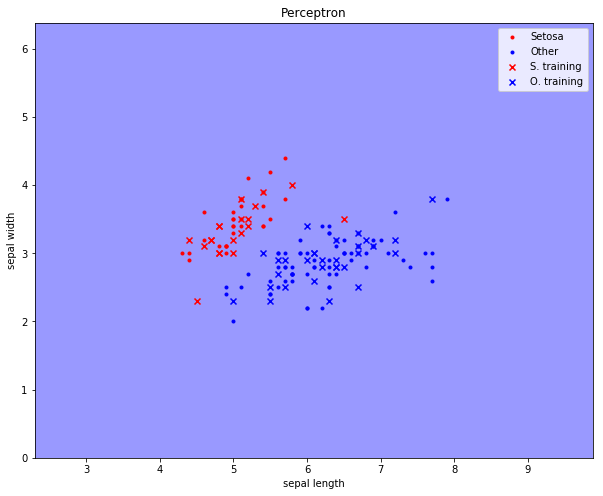

Epoch: 0
weights: [0. 0. 0.]
Efficiency (train) = 0.6
Efficiency (test)  = 0.7
Efficiency (all)   = 0.6666666666666667


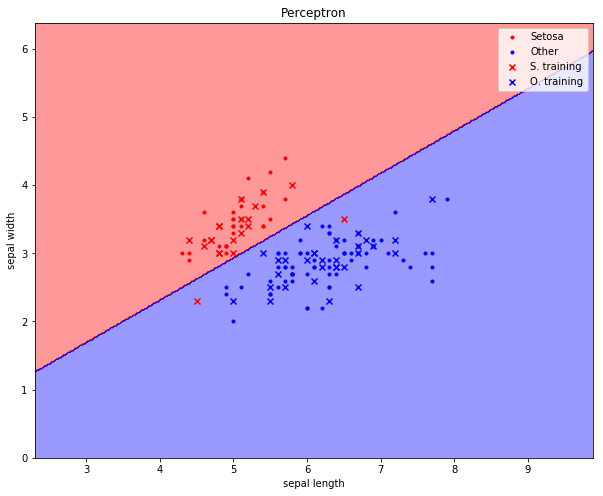

Epoch: 1
weights: [-0.2   0.72 -1.16]
Efficiency (train) = 0.96
Efficiency (test)  = 1.0
Efficiency (all)   = 0.9866666666666667


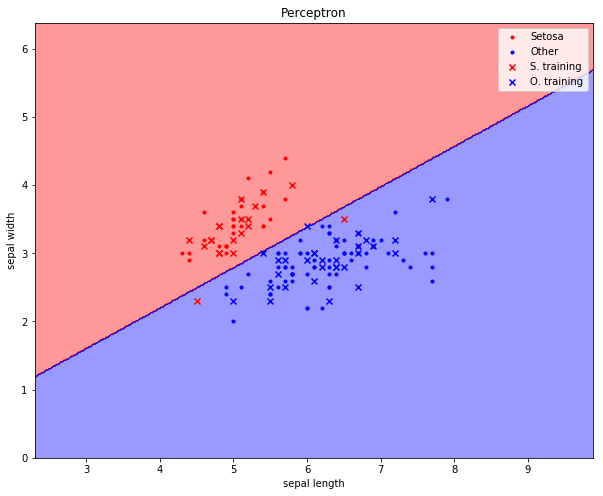

Epoch: 2
weights: [-0.4   1.34 -2.26]
Efficiency (train) = 0.94
Efficiency (test)  = 1.0
Efficiency (all)   = 0.98


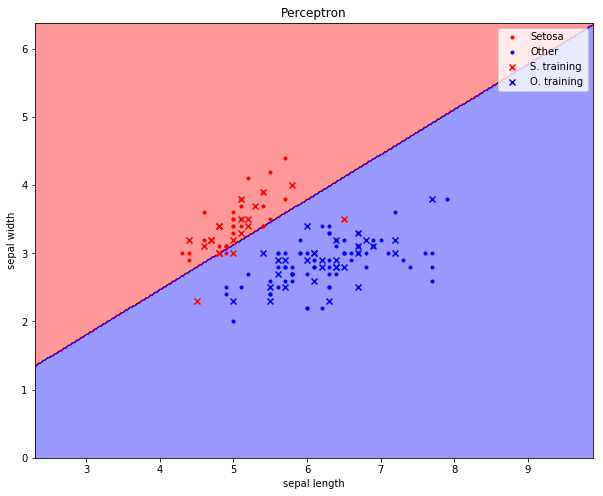

Epoch: 3
weights: [-0.4   1.48 -2.24]
Efficiency (train) = 0.94
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9733333333333334


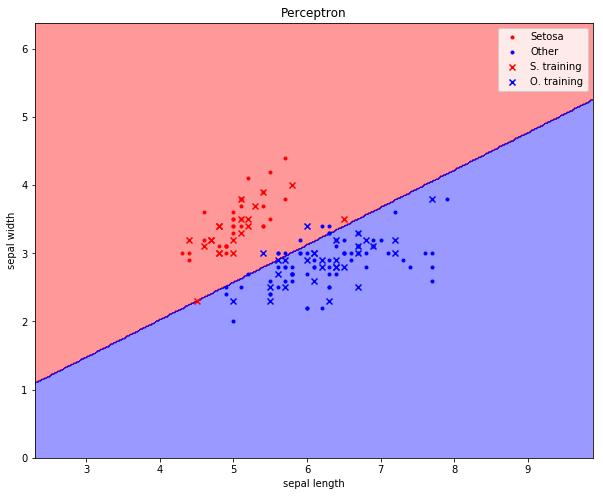

Epoch: 4
weights: [-0.6   1.9  -3.46]
Efficiency (train) = 0.96
Efficiency (test)  = 0.91
Efficiency (all)   = 0.9266666666666666


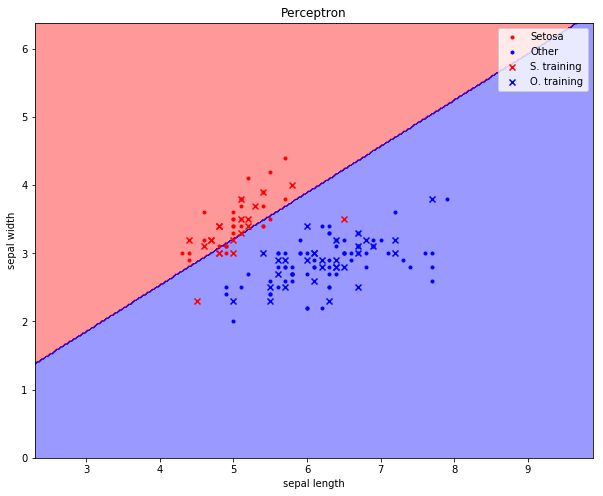

Epoch: 5
weights: [-0.6   2.2  -3.24]
Efficiency (train) = 0.88
Efficiency (test)  = 0.9299999999999999
Efficiency (all)   = 0.9133333333333333


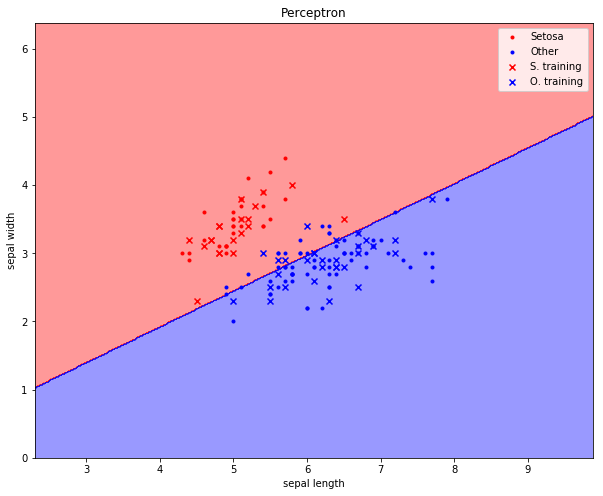

Epoch: 6
weights: [-0.8   2.3  -4.38]
Efficiency (train) = 0.9
Efficiency (test)  = 0.8200000000000001
Efficiency (all)   = 0.8466666666666667


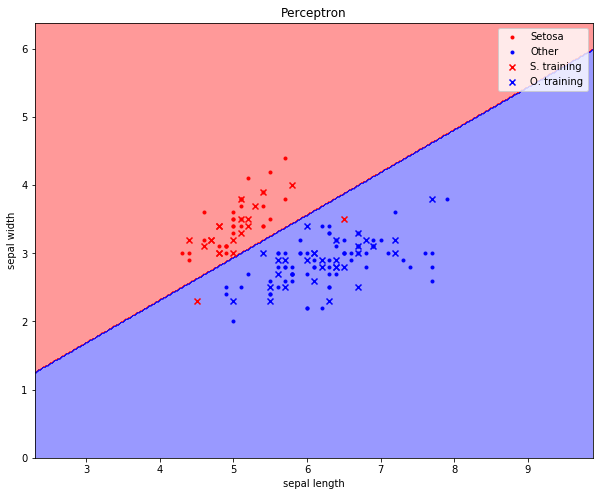

Epoch: 7
weights: [-0.8   2.6  -4.16]
Efficiency (train) = 0.96
Efficiency (test)  = 1.0
Efficiency (all)   = 0.9866666666666667


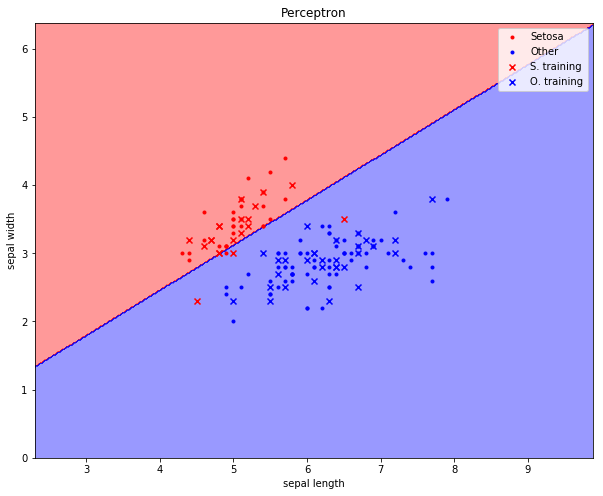

Epoch: 8
weights: [-0.8   2.74 -4.14]
Efficiency (train) = 0.94
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9733333333333334


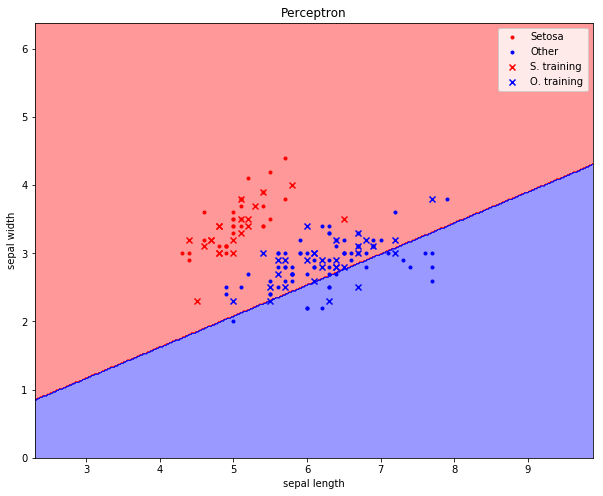

Epoch: 9
weights: [-1.    2.26 -4.96]
Efficiency (train) = 0.48
Efficiency (test)  = 0.44999999999999996
Efficiency (all)   = 0.45999999999999996


In [12]:
# fix the generated random numbers (2 seems to select a bad case)
np.random.seed(4)
# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

ppn = Perceptron(X.shape[1])

for e in range(10):
    
    ppn.plot_decision_regions(X, Y, X_train, Y_train, 0.02)
    eff_all = ppn.efficiency(X_all, Y_all)
    
    eff_train = ppn.efficiency(X_train, Y_train)
    eff_test = ppn.efficiency(X, Y)
    eff_all = ppn.efficiency(X_all, Y_all)
    
    plt.show()

    print('Epoch:', e )
    print('weights:', ppn.w_)
    print('Efficiency (train) =', eff_train)
    print('Efficiency (test)  =', eff_test)
    print('Efficiency (all)   =', eff_all)
    
    ppn.learn(X_train, Y_train, eta=0.1, epochs=1)

## Random data
The final section below can be used to study the Perceptron training algorithm with random data that is almost linearly separable. Play with the seed and learning rate to observe the training performance.

**HOMEWORK:** 
1. Classify the different scenarios and give explanations why the occur.
2. Is there a relation between a 'good' learning rate and the training data? HINT: For one data set, find a learning rate that allows sufficiently good efficiency. Scale the training data linearly and find again a good learning rate. How do the two learning rate relate to each other and what would be good practise when preparing the data set before training?

In [13]:
def generate_random_data(numItems, vecSize=2):
    '''
    generates num items of radom data
    Y: an array of classes '-1 or 1'
    X: the corresponding data vectors
    '''
    
    # generate class labels -1 and 1
    Y = np.ones(numItems) - 2 * np.random.randint(2, size=numItems)

    # generate the data on basis of which the distinction should be made
    X = np.random.rand(numItems, vecSize)

    for n in range(vecSize):
        X[:, n] = X[: ,n] - 2 * Y * np.random.rand(numItems)

    return X, Y

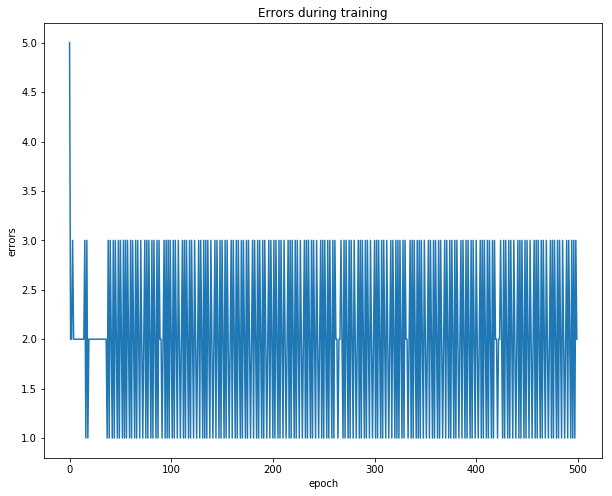

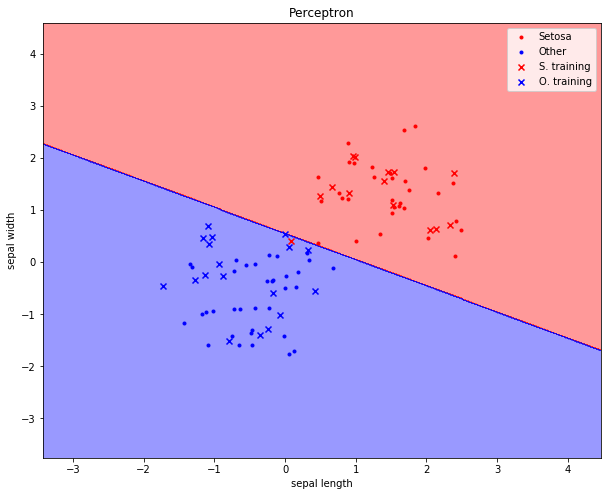

weights: [ 0.04       -0.03631416 -0.07220792]
Efficiency (train) = 0.9696969696969697
Efficiency (test)  = 1.0
Efficiency (all)   = 0.99


In [14]:
# fix the generated random numbers (2 seems to select a bad case)
np.random.seed(60)

# if you do not have the csv data file call fetch_iris_data() by removing the comment in the line below
# fetch_iris_data()

X_all, Y_all = generate_random_data(100)

# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )

# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]

# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
ppn = Perceptron(X.shape[1])
ppn.learn(X_train, Y_train, eta=0.01, epochs=500)
ppn.plot_train_errors()

ppn.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = ppn.efficiency(X_train, Y_train)
eff_test = ppn.efficiency(X, Y)
eff_all = ppn.efficiency(X_all, Y_all)

plt.show()

print('weights:', ppn.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

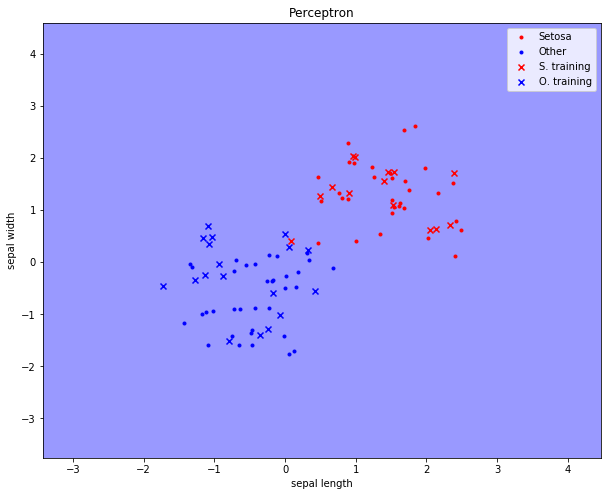

Epoch: 0
weights: [0. 0. 0.]
Efficiency (train) = 0.5454545454545454
Efficiency (test)  = 0.5223880597014925
Efficiency (all)   = 0.53


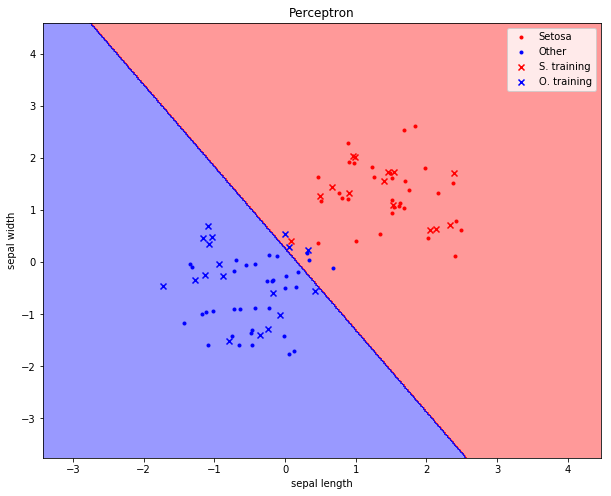

Epoch: 1
weights: [ 0.2        -1.16420432 -0.74072814]
Efficiency (train) = 0.9090909090909091
Efficiency (test)  = 0.9552238805970149
Efficiency (all)   = 0.94


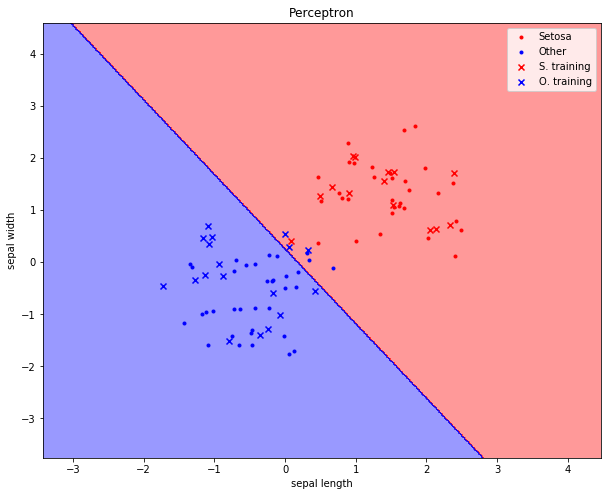

Epoch: 2
weights: [ 0.2        -1.11483364 -0.77805451]
Efficiency (train) = 0.9090909090909091
Efficiency (test)  = 0.9552238805970149
Efficiency (all)   = 0.94


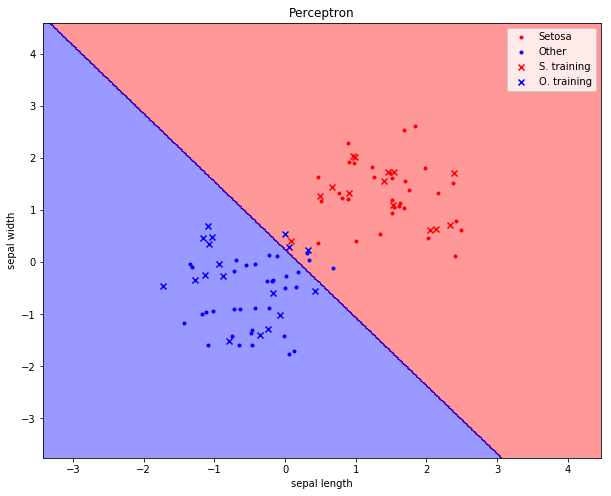

Epoch: 3
weights: [ 0.2        -1.06546297 -0.81538088]
Efficiency (train) = 0.9090909090909091
Efficiency (test)  = 0.9552238805970149
Efficiency (all)   = 0.94


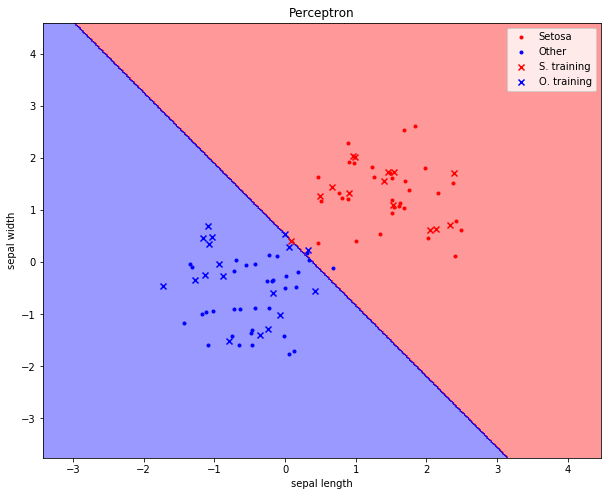

Epoch: 4
weights: [ 0.4        -1.01534611 -0.74470215]
Efficiency (train) = 0.9090909090909091
Efficiency (test)  = 0.9701492537313433
Efficiency (all)   = 0.95


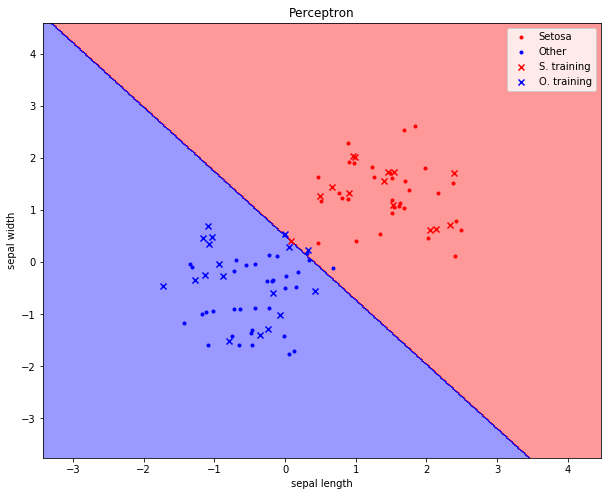

Epoch: 5
weights: [ 0.4        -0.96597543 -0.78202852]
Efficiency (train) = 0.9393939393939394
Efficiency (test)  = 0.9701492537313433
Efficiency (all)   = 0.96


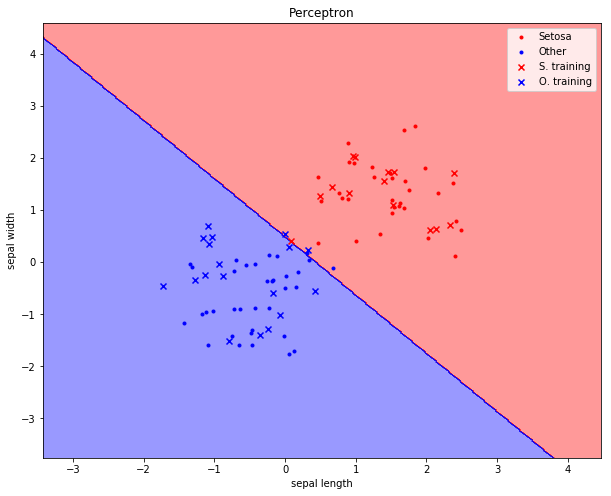

Epoch: 6
weights: [ 0.4        -0.91660476 -0.81935488]
Efficiency (train) = 0.9393939393939394
Efficiency (test)  = 0.9701492537313433
Efficiency (all)   = 0.96


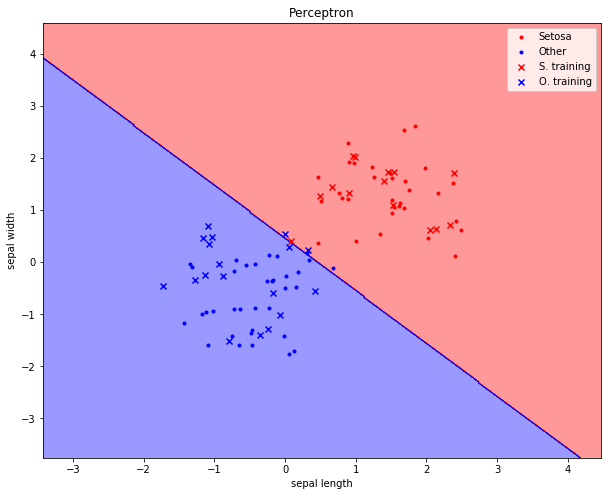

Epoch: 7
weights: [ 0.4        -0.86723408 -0.85668125]
Efficiency (train) = 0.9393939393939394
Efficiency (test)  = 0.9701492537313433
Efficiency (all)   = 0.96


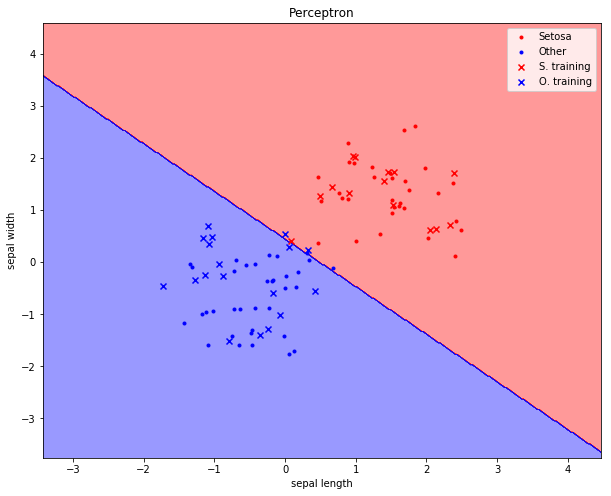

Epoch: 8
weights: [ 0.4        -0.81786341 -0.89400762]
Efficiency (train) = 0.9393939393939394
Efficiency (test)  = 0.9701492537313433
Efficiency (all)   = 0.96


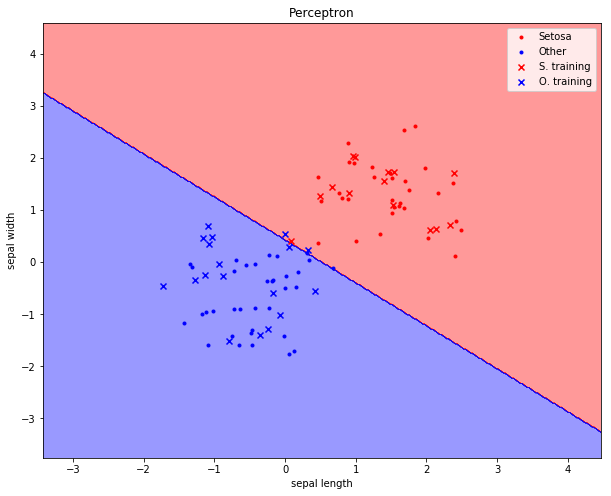

Epoch: 9
weights: [ 0.4        -0.76849273 -0.93133399]
Efficiency (train) = 0.9393939393939394
Efficiency (test)  = 0.9701492537313433
Efficiency (all)   = 0.96


In [15]:
ppn = Perceptron(X.shape[1])

for e in range(10):
    
    ppn.plot_decision_regions(X, Y, X_train, Y_train, 0.02)
    eff_all = ppn.efficiency(X_all, Y_all)
    
    eff_train = ppn.efficiency(X_train, Y_train)
    eff_test = ppn.efficiency(X, Y)
    eff_all = ppn.efficiency(X_all, Y_all)
    
    plt.show()

    print('Epoch:', e )
    print('weights:', ppn.w_)
    print('Efficiency (train) =', eff_train)
    print('Efficiency (test)  =', eff_test)
    print('Efficiency (all)   =', eff_all)
    
    ppn.learn(X_train, Y_train, eta=0.1, epochs=1)